### Python and Just-in-Time Compilation:

This is a quick lecture to take a look at the ways to improve the performance of interpreted code. We have been working with compiled code with OpenMP in C, so now let's jump back to interpreted code in Python.

* _Compilation_ is the process of generating machine code that can be run directly on a processor from source code written in a programming language.

* _Interpreters_ are programs that directly execute instructions written in a programming language without compilation.

There is a lot of gray area and confusion and reality will often blend these concepts. Let's consider the Java landscape. Java source code is _compiled_ into a intermediate representation (Java byte code) that run through some combination of:
  * a Java _interpreter_ that translates Java byte code to machine instructions
  * a just-in-time (JIT) compiler that translates byte code into machine code as the program executes

The concept of just-in-time compilation on interpreted languages is powerful in that it can realize the performance of compiled code while preserving the flexibility and ease of programming in interpreted code. Python has a JIT and we will explore performance of JIT compilation and its interaction with parallelism.

#### Mutual Web Outlinks Example

Returning to our Web Outlinks example. Let's start with a review of 
  * building a small graph
  * building a larger graph 
  * the serial mutual outlinks program
  * a `joblib` parallelized outlinks program (based on processes)
  

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

G = nx.erdos_renyi_graph(5,0.8, directed=True)

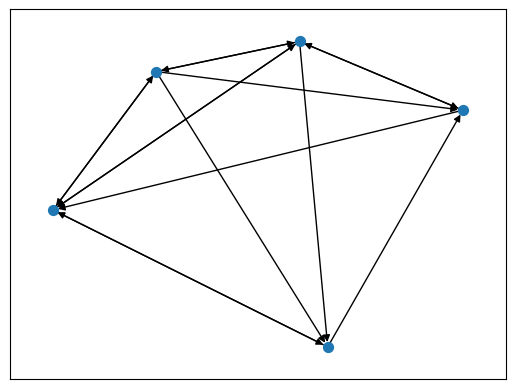

In [16]:
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False, node_size=50)

In [17]:
gmat = nx.to_numpy_array(G)

outmat = np.zeros(gmat.shape, dtype=np.float32)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(gmat[i,:], gmat[j,:])
outmat

array([[0., 2., 3., 2., 2.],
       [0., 0., 2., 1., 0.],
       [0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)

Now generate a big graph and we'll start our performance analysis. Let's look at a serial version on a graph with 1000 nodes and about 5 outbound edges per node. 

Serial program to calculate mutual outlinks.

9850

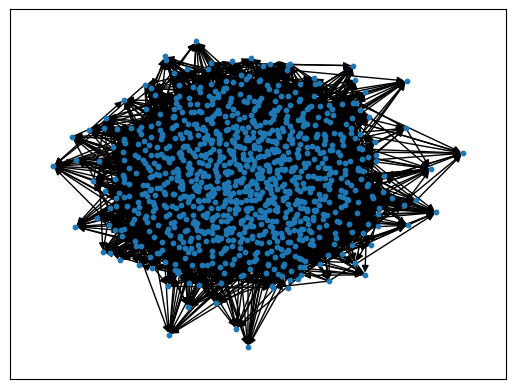

In [18]:
# cycles disappear when p = log(n)/n
G= nx.erdos_renyi_graph(1000,0.01,directed=True)
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False, node_size=10)
G.number_of_edges()

In [19]:
import numpy as np

gmat = nx.to_numpy_array(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(gmat[i,:], gmat[j,:])
        
np.count_nonzero(outmat)

46488

In [20]:
%%timeit
for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

1.93 s ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's a serial implementation. Let's parallelize it with `joblib`.

In [21]:
def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out
    
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(inner_loop)(i) for i in range(gmat.shape[0]))

outmat = np.array(partials)
np.count_nonzero(outmat)

46488

and time it

In [22]:
%%timeit
partials = Parallel(n_jobs=4)(delayed(inner_loop)(i) for i in range(gmat.shape[0]))

956 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK, this is where we stopped in Lecture 2.

### Numba 

Numba is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code.  Let's look at the outcome of compiling the inner loop of our serial implementation. This should reduce the number of calls to the interpreter to be O(rows) rather than O(rows*rows).

Read the 5-minute guide to Numba (https://numba.readthedocs.io/en/stable/user/5minguide.html)
  then do the following:
* import the numba jit
* add numba symbols and decorators to compile inner loop.

In [23]:
from numba import jit

outmat = np.zeros(gmat.shape)

@jit(nopython=True)
def comp_inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(gmat[i,:], gmat[j,:])  
    return partial_out
    
for i in range(gmat.shape[0]):
    outmat[i,:] = comp_inner_loop(i)

np.count_nonzero(outmat)

46488

In [24]:
%%timeit
for i in range(gmat.shape[0]):
    outmat[i,:] = comp_inner_loop(i)

1.16 s ± 6.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Numba and parallel for loops

OK, that is great. Let's try to compile the whole thing and add parrallelism to the outer loop. You will need to check out explicit parallelization at https://numba.readthedocs.io/en/stable/user/parallel.html.

In [30]:
from numba import jit, prange

@jit(nopython=True)
def comp_inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
   # print(partial_out)
    return partial_out

@jit(nopython=True, parallel=True)
def comp_outerloop(outmat):

    for i in prange(gmat.shape[0]):
        outmat[i,:] = comp_inner_loop(i)


outmat = np.zeros(gmat.shape)
comp_outerloop(outmat)
np.count_nonzero(outmat)

46488

In [26]:
%%timeit
comp_outerloop(outmat)

226 ms ± 6.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK that was pretty awesome. >3x speedup over compiled code.

### Performance

Manually grab all the timings from the notebook and drop them in this plot.

<Axes: >

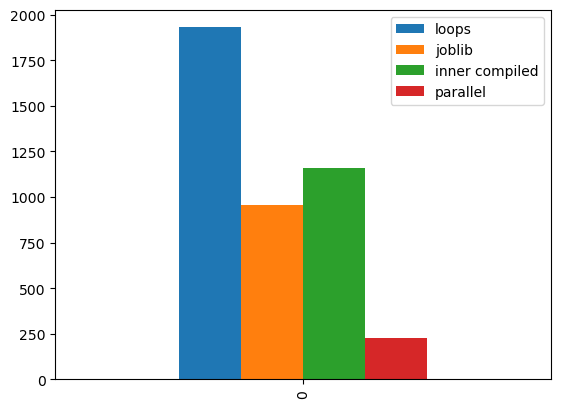

In [27]:
import pandas as pd

# get values from code
d = { 'loops': [1930], 'joblib': [956], 'inner compiled': [1160], 'parallel': [226] }
df = pd.DataFrame (data=d)
df.head()
df.plot.bar()

### Conclusions and Relationship with ILP

  * JIT Compilation is a powerful tool
  * JIT can only speed up the code that is compiled 
  * Numba has parallelization primitives for embarrassingly parallel code (only)
 
This is a pretty clear reminder that parallelism is only one of many speedup tools. It turns out to be useful here after we are running on compiled code, but in the big picture, compiling code to get access to ILP is equally important.